In [144]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

## Librerías

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from scipy.stats import shapiro


## Dataset

In [146]:
#Importando el dataset
url = "https://storage.googleapis.com/the_public_bucket/wine-clustering.csv"

# Lee el dataset como pandas dataframe
winedata = pd.read_csv(url)

## Data exploration

In [147]:
winedata.head() #Primera vista del dataset

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Con este primer vistazo notamos los rangos en los que se manejan las mediciones, notese que el aminoácido "proline" se registra en mayores cantidades, algo similar ocurre con el magnesio, al menos las primeras 5 filas. Se continuará con la exploración. 

In [148]:
print("Dimensiones del conjunto de datos de diabetes: {}".format(winedata.shape))

Dimensiones del conjunto de datos de diabetes: (178, 13)


In [149]:
winedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


Dadas las dimnsiones sabemos que hay 178 filas de las cuáles ninguna tiene contenido nulo

In [150]:
winedata.isna().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

Dado que nuestras variables son cuantitativas también nos aseguramos de que todos los registros sean valores numéricos, se observa que en efecto todos son números. 

De manera similar, al analizar cada atributo se intuye que no tendría sentido tener registros ceros en alguna de las características de los vinos, por lo que se comprueba su ausencia.

In [151]:
# Conteo de ceros
sumCeros = (winedata == 0).sum()

# Imprimir la cantidad de ceros por columna
print("Cantidad de ceros por columna:")
print(sumCeros)


Cantidad de ceros por columna:
Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64


In [152]:
# Cantidad de valores únicos de cada variable
winedata.nunique()

Alcohol                 126
Malic_Acid              133
Ash                      79
Ash_Alcanity             63
Magnesium                53
Total_Phenols            97
Flavanoids              132
Nonflavanoid_Phenols     39
Proanthocyanins         101
Color_Intensity         132
Hue                      78
OD280                   122
Proline                 121
dtype: int64

Los valores únicos obtenidos sugieren que hay valores repetidos, así que vale la pena revisar si alguna fila es duplicada

In [153]:
# Verificar filas duplicadas
numDuplicados = winedata.duplicated().sum()

print("Número de filas duplicadas:", numDuplicados)

Número de filas duplicadas: 0


Comprobamos que no es necesario quitar duplicados

In [154]:
winedata.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Las medias y las desviaciones estándar nos dicen mucho de las distribuciones de los datos. Por ejemplo, el alcohol tiene una media más cercana al valor máximo del conjunto lo cuál sugiere asimetría, además posee una desviación estándar que indica poca dispersión lo cuál tiene sentido con el rango tan reducido que se obtiene (entre 11.03 y 14.83), esto habla de que la cantidad de alcohol no cambia tanto entre los tipos de vinos), mientras que otros componentes como proline muestran una enorme dispersión por lo que sería interesante revisar las posibles razones para esto. Por otro lado la variable "Ash_Alcanity" tiene una media (19.49) que parece estar prácticamente a la mitad del rango de registro (10.6 - 30) o mediana, misma que se obtendrá mas adelante. 

Ya que algunas características sugieren distribuciones no-normales, no sería factible realizar modelos de regresión lineal 
o la realización de análisis de varianza ANOVA en grupos generados por un modelo de clusterización ya que no cumpliría los supuestos necesarios, en su lugar sería mejor optar por un proceso de clustering. 

In [155]:
# Mediana
print("Mediana:")
print(winedata.median())

Mediana:
Alcohol                  13.050
Malic_Acid                1.865
Ash                       2.360
Ash_Alcanity             19.500
Magnesium                98.000
Total_Phenols             2.355
Flavanoids                2.135
Nonflavanoid_Phenols      0.340
Proanthocyanins           1.555
Color_Intensity           4.690
Hue                       0.965
OD280                     2.780
Proline                 673.500
dtype: float64


Como se mencionó anteriormente, la columna "Ash Alcalinity" tiene una mediana de 19.5 y una media de 19.49 lo cuál nos acerca a la distribución normal

Dado que tenemos más de 50 datos podemos aplicar una prueba shapiro para determinar qué variables se acercan a una distribución normal y cuáles no, aunque es necesario aclarar que al no rechazar la hipótesis tampoco se puede asegurar que los datos sigan una distribución normal, sin embargo, es bastante probable. 


**Hipótesis Nula ($H_0$):** Los datos siguen una distribución normal.

**Hipótesis Alternativa ($H_1$):** Los datos no siguen una distribución normal.

**Valor α:** 0.05

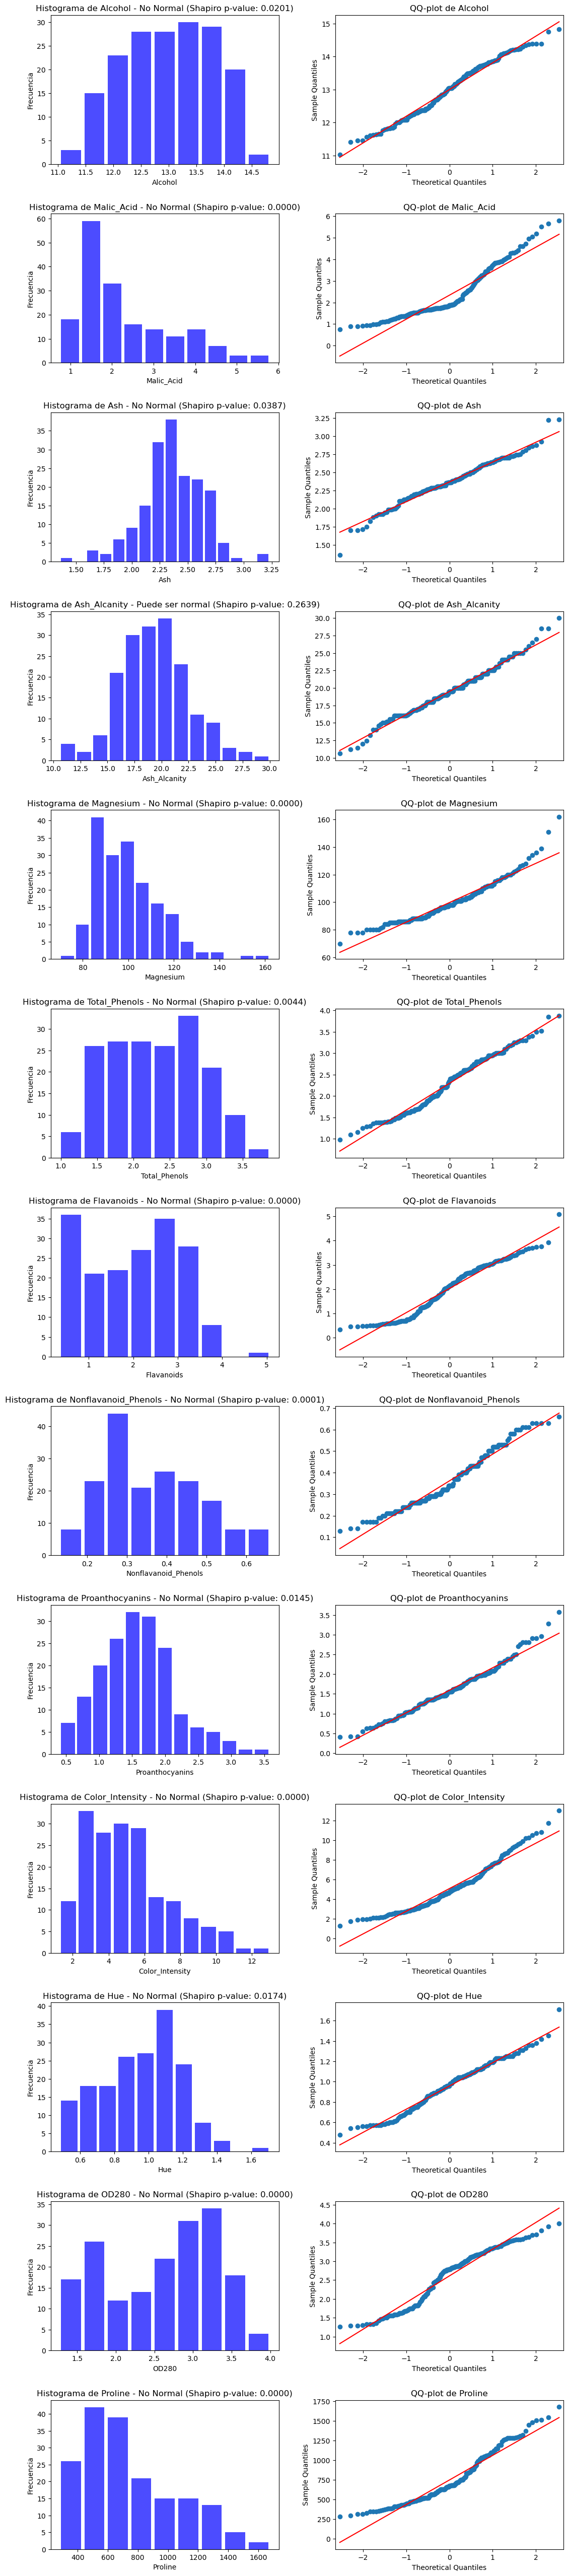

In [156]:
# Lista de columnas en el conjunto de datos
columnas = winedata.columns

# Nivel de significancia
alpha = 0.05

# Número de filas y columnas para el acomodo de los subgráficos
num_filas = len(columnas)
num_columnas = 2

# Configuración de subgráficos
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, num_filas * 4))
fig.tight_layout(pad=5.0)

# Bucle
for i, columna in enumerate(columnas):
    # Extraer los datos de la columna
    data = winedata[columna]

    # Shapiro-Wilk
    stat, p_value = shapiro(data)

    # Resultados prueba shapiro
    if p_value > alpha:
        normality_result = "Puede ser normal"
    else:
        normality_result = "No Normal"

    # Histograma
    axs[i, 0].hist(data, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
    axs[i, 0].set_title(f'Histograma de {columna} - {normality_result} (Shapiro p-value: {p_value:.4f})')
    axs[i, 0].set_xlabel(columna)
    axs[i, 0].set_ylabel('Frecuencia')

    # QQ-plot
    sm.qqplot(data, line='s', ax=axs[i, 1])
    axs[i, 1].set_title(f'QQ-plot de {columna}')

plt.show()


Se realizaron las pruebas de las cuáles se obtiene que la única característica posiblemente con distribución nornal es tal como se veía previniendo, Ash Alcalinity.

Además añaden los histogramas y gráficas QQ-plot para visualizar mejor cómo se ajusta cada conjunto de datos 
perteneciente a cada químico presente en los vinos a lo que sería una distribuión normal.

En cuanto a los hitogramas, se oberva que todos los registros de los compuestos, excepto Ash y OD280, tienen sesgos a
la derecha lo cuál significa que los registros tienden a ser en cantidades menores ya que cuentan con un alargamiento
en la cola correspondiente a los valores altos altos, en cuanto a interpretaciones en un contexto real de los vinos se 
puede destacar lo siguiente:

- Viinos con valores extremadamente altos en las variables podrían considerarse excepcionales o únicos en términos
de características sensoriales o composición química. Esto podría ser una oportunidad d estudio para los interesados 
en el vino, como la presencia de prolina que a pesar de que en la mayoría de los vinos tiene un valor entre 500 y 700, 
hay una poca cantidad de vinos que llegan a tener un registro de más de 1600

- Para los enólogos, el conocimiento de que la mayor parte de los registros para casi todas las características 
tienden a ser valores bajos comparados con los máximos que toman menor parte, podría influir en 
decisiones sobre prácticas de vinificación, selección de uvas, o métodos de producción para equilibrar o potenciar
esas características.
- En cuanto a la revisión de estándares, Dependiendo de las regulaciones y estándares de la industria del vino,
los valores extremadamente altos podrían tener implicaciones para la conformidad con ciertos criterios de calidad 
o etiquetado.

Respecto a las gráficas QQ-plot se oberva que a pesar de todo la mayoría de las características tienen un buen ajuste a la de una distribución normal exceptuando las colas (por lo cuál podría sugerir una regresión logarítmica). Los datos correspondientes a "OD80" y principalmente los de "Flavanoids" tienen una forma más distintiva que podría amoldarse mejor a una distribución logística. 

La diferencia en la forma de estas distribuciones podría indicar que "OD80" y "Flavanoids" son características únicas o clave en el conjunto de datos de vinos. Podrían ser componentes críticos que contribuyen significativamente a la variabilidad y calidad de los vinos. Además, los flavonoides son conocidos por sus efectos antioxidantes; por lo tanto, variaciones en su concentración pueden ser de interés enológico

In [157]:
# Calcular el rango intercuartílico (IQR) para cada variable
Q1 = winedata.quantile(0.25)
Q3 = winedata.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Encontrar outliers
outliers = (winedata < lower_bound) | (winedata > upper_bound)

# Contar el número de outliers por variable
outliers_count = outliers.sum()

# Imprimir el número de outliers por variable
print("Número de outliers por variable:")
print(outliers_count)


Número de outliers por variable:
Alcohol                 0
Malic_Acid              3
Ash                     3
Ash_Alcanity            4
Magnesium               4
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         2
Color_Intensity         4
Hue                     1
OD280                   0
Proline                 0
dtype: int64


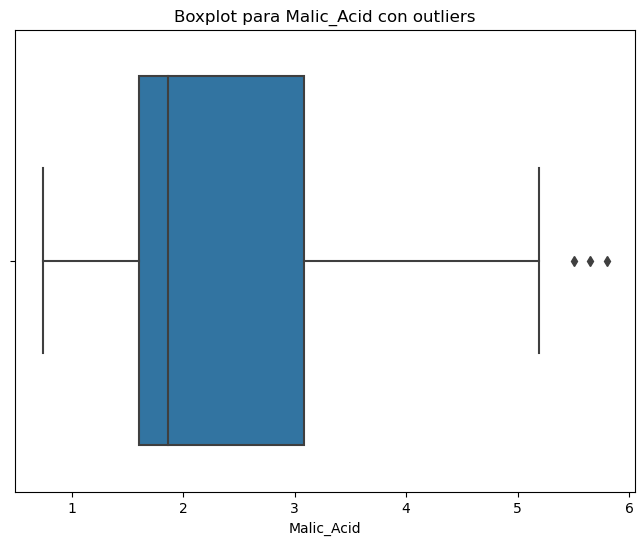

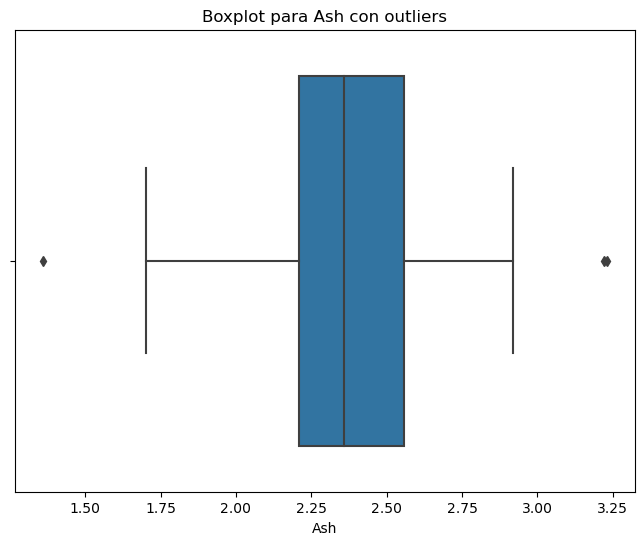

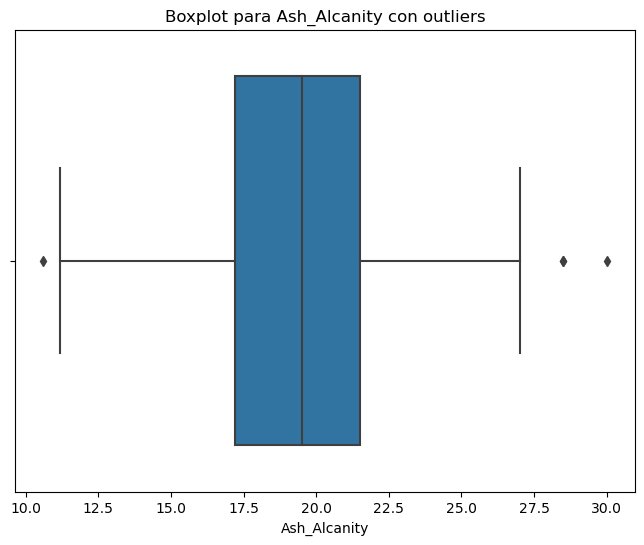

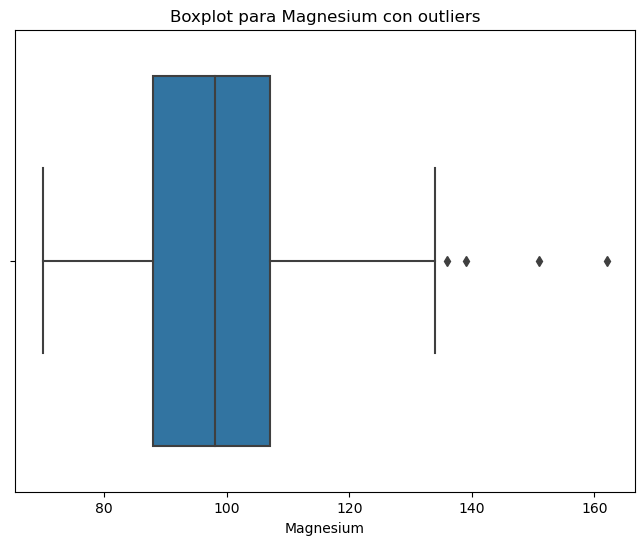

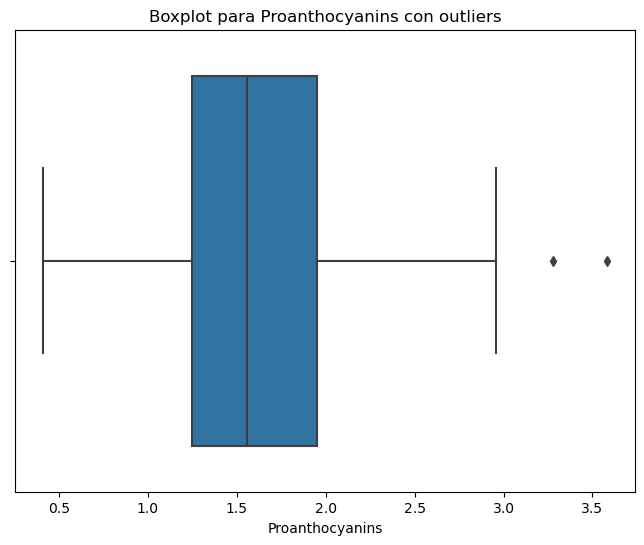

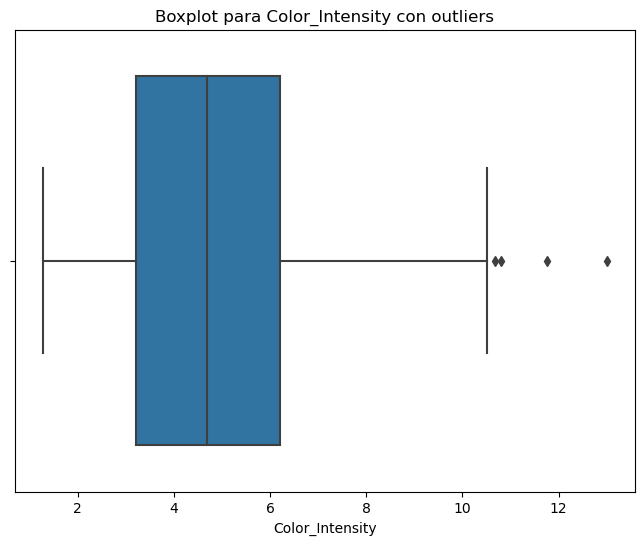

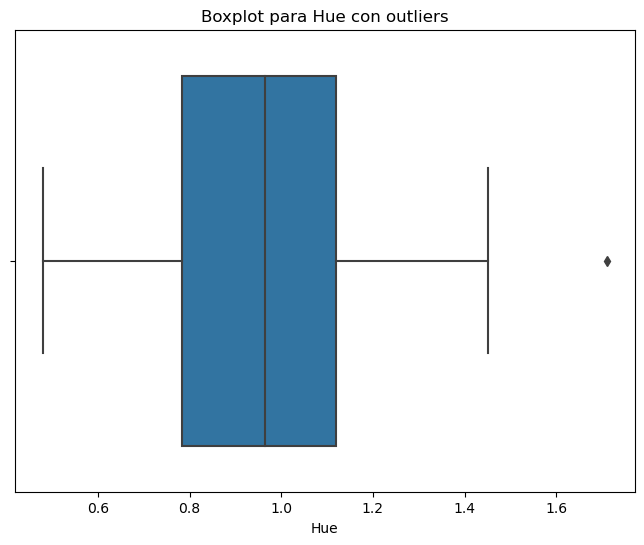

In [158]:
# Calcular el rango intercuartílico (IQR) para cada variable
Q1 = winedata.quantile(0.25)
Q3 = winedata.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Encontrar outliers
outliers = (winedata < lower_bound) | (winedata > upper_bound)

# Contar el número de outliers por variable
outliers_count = outliers.sum()

# Filtrar variables con outliers
variables_con_outliers = outliers_count[outliers_count > 0].index

# Crear un boxplot para cada variable con outliers
for variable in variables_con_outliers:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=winedata[variable])
    plt.title(f'Boxplot para {variable} con outliers')
    plt.show()


Los datos se manejan en rangos muy distintos, al menos la columna proline, por lo que por ahora se realizan boxplots para las variables con outliers y después, en el clústering se realizará el escalamiento de los datos

Se observan algunos datos atípicos en ciertas variables, se decide no eliminarlos pues no hay certeza de que se deba a un error de registro, puede sugerir anormalidades en cuanto a la presencia de estos componentes en ciertos vinos. 

Ahora se revisará la correlación, la cuál se obtendrá con el método spearman. Dado que en la base de datos de vinos casi ninguna variable sigue una distribución normal y contiene algunos valores atípicos, el coeficiente de Spearman proporciona una medida más robusta de la relación entre las variables. Además, el coeficiente de Spearman es útil incluso cuando las relaciones entre las variables no son lineales y se prefiere una medida que capture asociaciones generales sin depender de la forma específica de la relación.

In [159]:
winedata.corr(method='spearman')


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Alcohol,1.000000,0.140430,0.243722,-0.306598,0.365503,0.310920,0.294740,-0.162207,0.192734,0.635425,-0.024203,0.103050,0.633580
Malic_Acid,0.140430,1.000000,0.230674,0.304069,0.080188,-0.280225,-0.325202,0.255236,-0.244825,0.290307,-0.560265,-0.255185,-0.057466
Ash,0.243722,0.230674,1.000000,0.366374,0.361488,0.132193,0.078796,0.145583,0.024384,0.283047,-0.050183,-0.007500,0.253163
Ash_Alcanity,-0.306598,0.304069,0.366374,1.000000,-0.169558,-0.376657,-0.443770,0.389390,-0.253695,-0.073776,-0.352507,-0.325890,-0.456090
Magnesium,0.365503,0.080188,0.361488,-0.169558,1.000000,0.246417,0.233167,-0.236786,0.173647,0.357029,0.036095,0.056963,0.507575
Total_Phenols,0.310920,-0.280225,0.132193,-0.376657,0.246417,1.000000,0.879404,-0.448013,0.666689,0.011162,0.439457,0.687207,0.419470
Flavanoids,0.294740,-0.325202,0.078796,-0.443770,0.233167,0.879404,1.000000,-0.543897,0.730322,-0.042910,0.535430,0.741533,0.429904
Nonflavanoid_Phenols,-0.162207,0.255236,0.145583,0.389390,-0.236786,-0.448013,-0.543897,1.000000,-0.384629,0.059639,-0.267813,-0.494950,-0.270112
Proanthocyanins,0.192734,-0.244825,0.024384,-0.253695,0.173647,0.666689,0.730322,-0.384629,1.000000,-0.030947,0.342795,0.554031,0.308249
Color_Intensity,0.635425,0.290307,0.283047,-0.073776,0.357029,0.011162,-0.042910,0.059639,-0.030947,1.000000,-0.418522,-0.317516,0.457096


In [160]:
correlation_matrix = winedata.corr(method='spearman') .round(2)

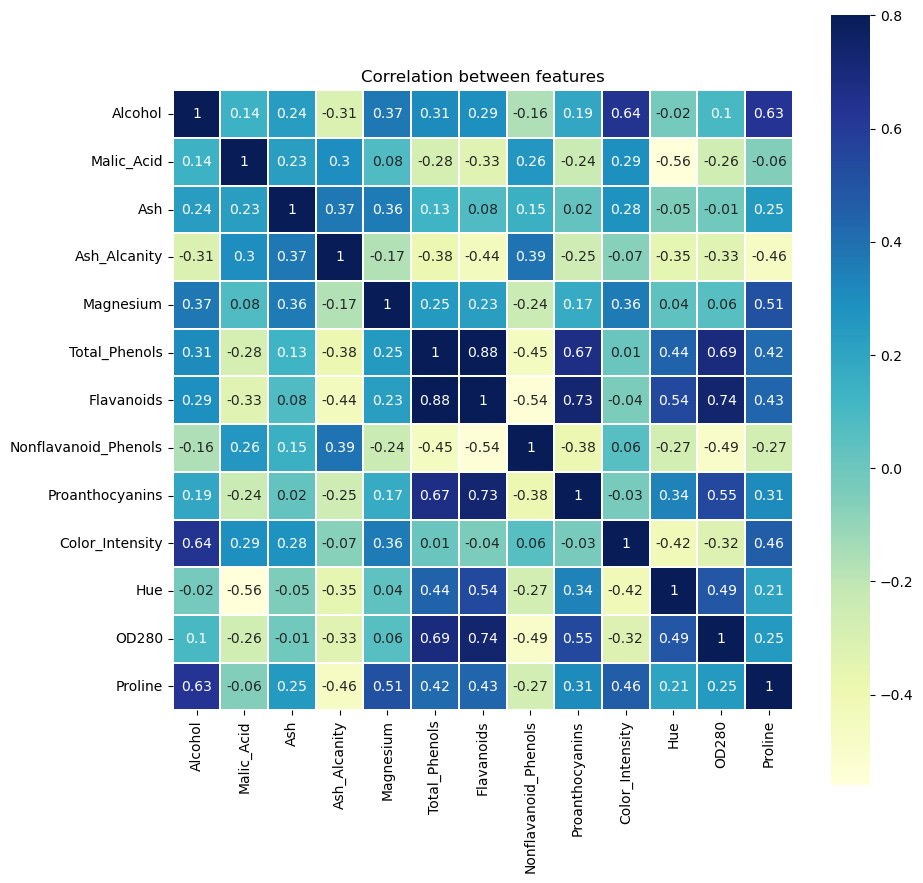

In [161]:
plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

Se identifica una alta correlación (88%) entre las variables "Total_Phenols" y "Flavanoids". Entrando en contexto se oobtienen las siguientes implicaciones:

1. **Perfil de Sabor y Aroma:** Ambas variables, los fenoles totales y los flavonoides, son compuestos químicos que contribuyen significativamente al perfil de sabor y aroma de los vinos. Un aumento en la concentración de uno podría estar asociado con un aumento similar en el otro, lo que podría influir en las características organolépticas del vino.

2. **Origen de la Uva:** La correlación puede sugerir que las condiciones del suelo, el clima o la cepa de uva específica en la región de cultivo podrían estar influyendo en ambas variables de manera similar. Esto podría ser de interés para los productores de vinos que buscan comprender las características distintivas de los vinos de una región en particular.

3. **Impacto en la Salud:** Tanto los fenoles como los flavonoides se han asociado con beneficios para la salud debido a sus propiedades antioxidantes. La correlación podría tener implicaciones para la percepción de los beneficios para la salud de consumir vinos ricos en estas sustancias.

4. **Procesos de Vinificación:** La correlación podría deberse a procesos específicos de vinificación utilizados en la producción de vinos. Por ejemplo, ciertas prácticas de maceración podrían influir en ambas variables de manera similar.


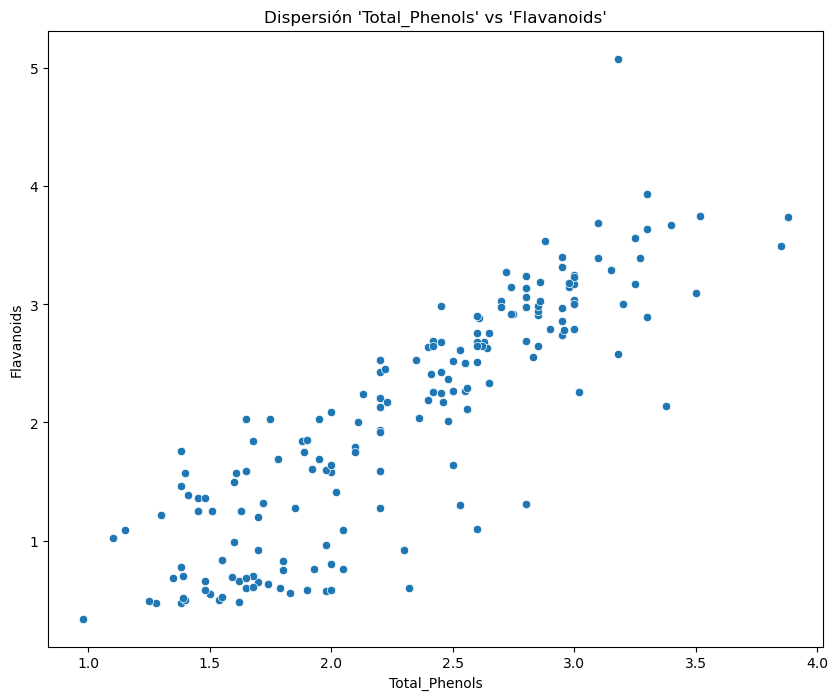

In [162]:
# Gráfico de dispersión para las variables "Total_Phenols" y "Flavanoids"
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Total_Phenols', y='Flavanoids', data=winedata)
plt.title("Dispersión 'Total_Phenols' vs 'Flavanoids'")
plt.show()


Se acompaña el resultado de la correlación con un gráfico de dispersión que sugiere una relación positiva entre estas dos variables

## Clustering Analysis

Cómo se ha visto, los datos necesitan ser escalados para tener un mejor rendimiento debido a la sensibilidad de las técnicas comunes de clusterización

In [163]:
# Estandarizar los datos
scaler = StandardScaler()
wineEscalado = scaler.fit_transform(winedata)

En esta sección se aplicarán diferentes técnicas y sus respectivos ajustes de parámetros, estas técnicas son:
- Spectral clustering
- K means
- GMM

### K- means

K-Means es adecuado para este conjunto de datos de vinos debido a su eficiencia en la identificación de patrones naturales (como el hecho de que sabemos que los datos pertenecen a tre tipos de vino) y su capacidad para generar clusters fácilmente interpretables. Facilita la comprensión de la diversidad de vinos basada en características específicas. Para encontrar el número óptimo de clusters se utilizarán dos criterios, inertia o SSE y silhouette, esto debido a que la Inertia (Suma de Errores Cuadráticos) se utiliza minimiza la varianza dentro de los clústeres, promoviendo grupos más cohesivos mientras que el silhouette Score evalúa la cohesión y separación entre clústeres de tal forma que un alto Silhouette Score indica una buena estructura de clústeres, la elección del número de clústeres se basa en maximizar este puntaje, garantizando clusters bien definidos y separados en el espacio de características.

La elección de usar el método del codo para hallar nuestros números adecuados de clústeres se debe a la búsqueda de un equilibrio que nos permita seleccionar un número óptimo de clústeres basado, en caso del SS,E en que la inercia comienza a disminuir significativamente y a partir de allí no haya un nivel significativo de mejor explicación de la varianza; o en caso de silhuette score encontrar el valor más alto. A final de cuentas se busca un equilibrio donde se tenga un número de clusters adecuado para estudiar las similitudes que comparten los alementos dentro del grupo así como las diferencias entre grupos, siendo este número razonable para una buena interpretación del problema, no tiene caso tener tan pocos clusters que no se pueda hallar diferencias significativas entre grupos así como tampoco funciona tener tantos clusters (incluso llegar al número de registros) ya que si bien toda la variabilidad llegaría a ser explicada, no se podría hallar patrones o similudes que nos lleven a conclusiones de valor. 

#### K óptimo por SSE

In [164]:
# Calcular la inercia para diferentes valores de k
inertia_values = [] #SSE - Sum of Squared Errors
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
    kmeans.fit(wineEscalado)
    inertia_values.append(kmeans.inertia_)

In [165]:
# Encontrar el codo usando kneed
kneedle = KneeLocator(range(1, 13), inertia_values, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

print(f"Número óptimo de clusters (K): {optimal_k}")

Número óptimo de clusters (K): 3


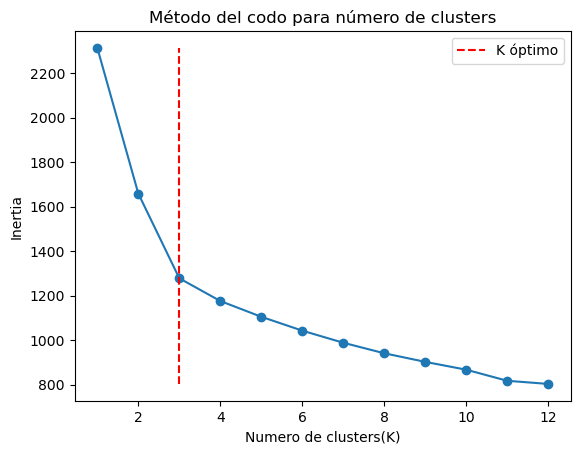

In [166]:
# Visualización del codo
plt.plot(range(1, 13), inertia_values, marker='o')
plt.xlabel('Numero de clusters(K)')
plt.ylabel('Inertia')
plt.title('Método del codo para número de clusters')
plt.vlines(optimal_k, ymin=min(inertia_values), ymax=max(inertia_values), linestyle='--', color='red', label='K óptimo')
plt.legend()
plt.show()

#### K óptimo por Silhouette Score 

In [167]:
# Calcular el Silhouette Score para diferentes valores de k
silhouette_scores = []
for k in range(2, 13):  # Silhouette Score requiere al menos 2 clusters
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(wineEscalado)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(wineEscalado, labels)
    silhouette_scores.append(silhouette_avg)

In [168]:
# Encontrar el número óptimo de clusters basado en el máximo Silhouette Score
optimal_k = np.argmax(silhouette_scores) + 2  # Sumar 2 porque empezamos desde k=2

print(f"Número óptimo de clusters (K): {optimal_k}")

Número óptimo de clusters (K): 3


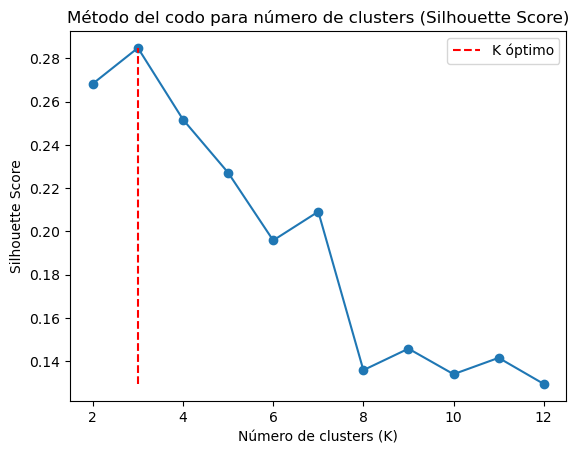

In [169]:
# Visualización de la gráfica
plt.plot(range(2, 13), silhouette_scores, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Método del codo para número de clusters (Silhouette Score)')
plt.vlines(optimal_k, ymin=min(silhouette_scores), ymax=max(silhouette_scores), linestyle='--', color='red', label='K óptimo')
plt.legend()
plt.show()


#### Inicialización y visualización

In [170]:
# Inicializar k means
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(wineEscalado)

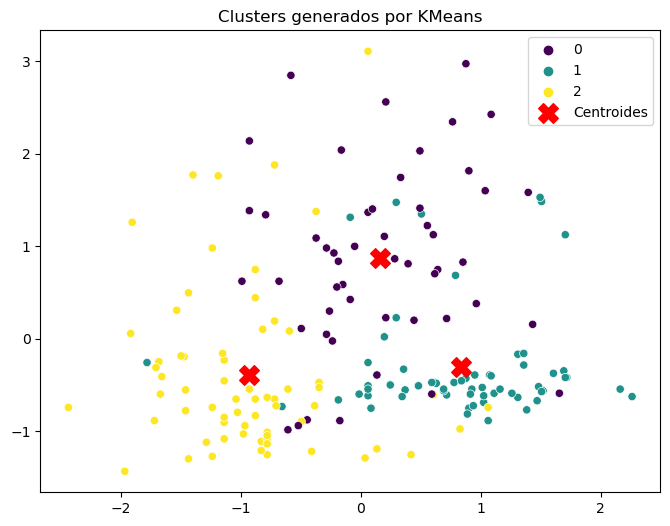

In [171]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wineEscalado[:, 0], y=wineEscalado[:, 1], hue=labels, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroides')
plt.title('Clusters generados por KMeans')
plt.legend()
plt.show()

### Spectral clustering

El Spectral Clustering se considera en el contexto de Data Wine debido a su capacidad para descubrir estructuras complejas y no lineales en los datos. A diferencia de K-Means, Spectral Clustering puede manejar conjuntos de datos no lineales y detectar agrupamientos con formas más complejas.

Para esta técnica no sólo se va a buscar el mejor k en base al SSE y silhuette score sino que también se "jugará" con el parámetro de affinity nearest_neighbors o rbf

Explorar dichos parámetros en affinity es crucial para adaptarse a la naturaleza y complejidad de los datos en el conjunto de vinos. La elección del parámetro de afinidad impacta directamente en cómo se mide la similitud entre puntos, permitiendo capturar relaciones locales o globales en el espacio de características.

Al ajustar tanto el número de clusters (k) como el tipo de afinidad, se busca encontrar la configuración óptima que revele la estructura subyacente en los datos de vinos, considerando tanto la forma de los clusters como la naturaleza de las relaciones entre puntos. Esta estrategia más completa permite una exploración exhaustiva.

#### K óptimo con SSE y affinity = 'nearest_neighbors'

In [172]:
sse = []

for k in range(2, 13):
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral.fit(wineEscalado)
    similarity = pairwise_distances(wineEscalado, metric='cosine')

    inertia = 0
    for cluster in range(k):
        cluster_points = wineEscalado[spectral.labels_ == cluster]
        affinity_subset = similarity[spectral.labels_ == cluster][:, spectral.labels_ == cluster]
        eigenvalues, eigenvectors = np.linalg.eig(affinity_subset)
        first_eigenvector = eigenvectors[:, np.argsort(eigenvalues)[1]]
        centroid = np.sum(first_eigenvector.reshape(-1, 1) * cluster_points, axis=0) / np.sum(first_eigenvector)
        distance = np.linalg.norm(wineEscalado[spectral.labels_ == cluster] - centroid, axis=1)
        inertia += np.sum(distance ** 2)

    sse.append(inertia)


In [173]:
# Encontrar el codo usando kneed
kneedle = KneeLocator(range(2, 13), sse, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

print(f"Número óptimo de clusters (K): {optimal_k}")

Número óptimo de clusters (K): 2


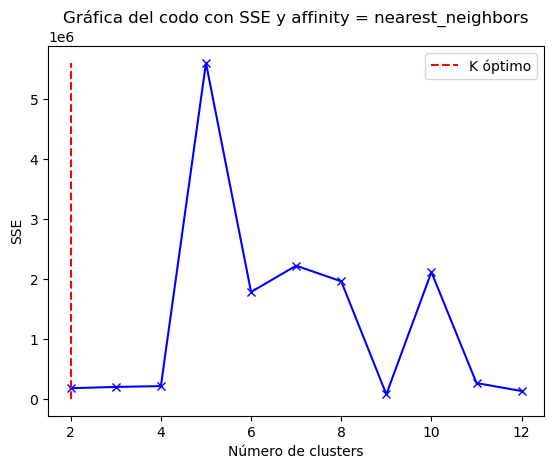

In [176]:
# Gráfica de SSE vs. número de clusters
plt.plot(range(2, 13), sse, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Gráfica del codo con SSE y affinity = nearest_neighbors')
plt.vlines(optimal_k, ymin=min(silhouette_scores), ymax=max(sse), linestyle='--', color='red', label='K óptimo')
plt.legend()
plt.show()


Al utilizar estos parámetros se obtiene una con muchos picos, lo cuál significa que la estructura de los datos no es fácil de identificar, están dispersos.

#### K óptimo con SSE y affinity = 'rbf' 

In [177]:
sse = []

for k in range(2, 11):
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='rbf')
    spectral.fit(wineEscalado)
    similarity = pairwise_distances(wineEscalado, metric='cosine')

    inertia = 0
    for cluster in range(k):
        cluster_points = wineEscalado[spectral.labels_ == cluster]
        affinity_subset = similarity[spectral.labels_ == cluster][:, spectral.labels_ == cluster]
        eigenvalues, eigenvectors = np.linalg.eig(affinity_subset)
        first_eigenvector = eigenvectors[:, np.argsort(eigenvalues)[1]]
        centroid = np.sum(first_eigenvector.reshape(-1, 1) * cluster_points, axis=0) / np.sum(first_eigenvector)
        distance = np.linalg.norm(wineEscalado[spectral.labels_ == cluster] - centroid, axis=1)
        inertia += np.sum(distance ** 2)

    sse.append(inertia)

In [178]:
# Encontrar el codo usando kneed
kneedle = KneeLocator(range(2, 11), sse, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

print(f"Número óptimo de clusters (K): {optimal_k}")

Número óptimo de clusters (K): 3


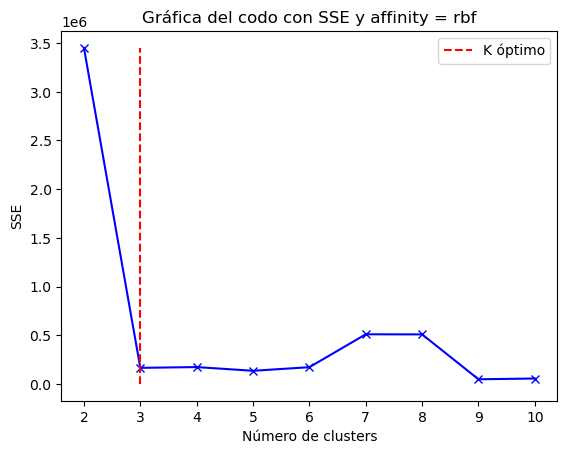

In [179]:
# Gráfica de SSE vs. número de clusters
plt.plot(range(2, 11), sse, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Gráfica del codo con SSE y affinity = rbf')
plt.vlines(optimal_k, ymin=min(silhouette_scores), ymax=max(sse), linestyle='--', color='red', label='K óptimo')
plt.legend()
plt.show()

#### K óptimo con silhouette_scores y affinity = 'nearest_neighbors'

In [180]:
silhouette_scores = []

for k in range(2, 11):
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    labels = spectral.fit_predict(wineEscalado)
    
    # Calcular el Silhouette Score
    silhouette_avg = silhouette_score(wineEscalado, labels)
    silhouette_scores.append(silhouette_avg)


In [181]:
# Encontrar el número óptimo de clusters basado en el máximo Silhouette Score
optimal_k = np.argmax(silhouette_scores) + 2  # Sumar 2 porque empezamos desde k=2

print(f"Número óptimo de clusters (K): {optimal_k}")

Número óptimo de clusters (K): 3


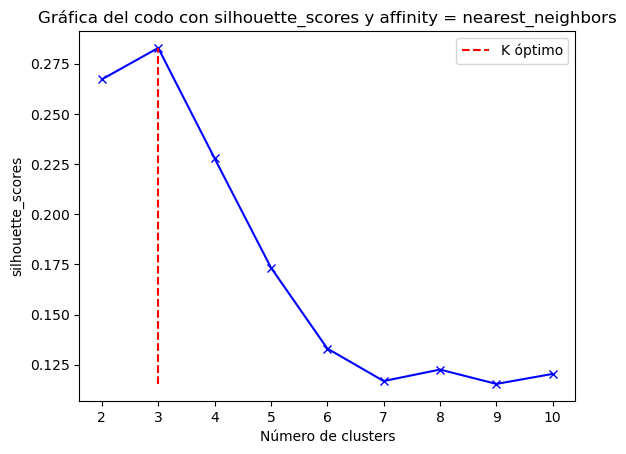

In [182]:
# Gráfica de Silhouette vs. número de clusters
plt.plot(range(2, 11),  silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('silhouette_scores')
plt.title('Gráfica del codo con silhouette_scores y affinity = nearest_neighbors')
plt.vlines(optimal_k, ymin=min(silhouette_scores), ymax=max(silhouette_scores), linestyle='--', color='red', label='K óptimo')
plt.legend()
plt.show()

#### K óptimo con silhouette_scores y affinity = 'rbf'

In [183]:
silhouette_scores = []

for k in range(2, 11):
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='rbf')
    labels = spectral.fit_predict(wineEscalado)
    
    # Calcular el Silhouette Score
    silhouette_avg = silhouette_score(wineEscalado, labels)
    silhouette_scores.append(silhouette_avg)


In [184]:
# Encontrar el número óptimo de clusters basado en el máximo Silhouette Score
optimal_k = np.argmax(silhouette_scores) + 2  # Sumar 2 porque empezamos desde k=2

print(f"Número óptimo de clusters (K): {optimal_k}")

Número óptimo de clusters (K): 5


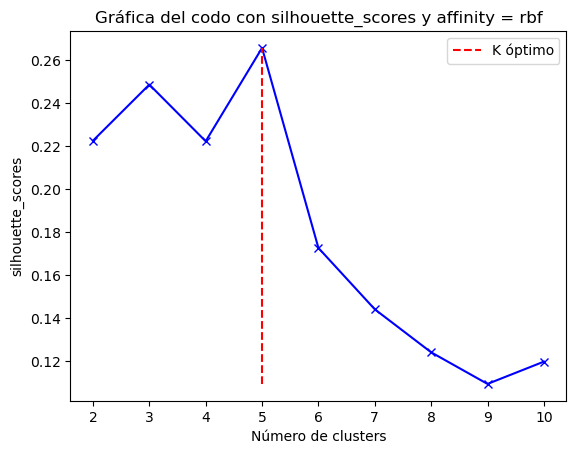

In [185]:
# Gráfica de Silhouette vs. número de clusters
plt.plot(range(2, 11),  silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('silhouette_scores')
plt.title('Gráfica del codo con silhouette_scores y affinity = rbf')
plt.vlines(optimal_k, ymin=min(silhouette_scores), ymax=max(silhouette_scores), linestyle='--', color='red', label='K óptimo')
plt.legend()
plt.show()

#### Inicialización de modelos y visualización

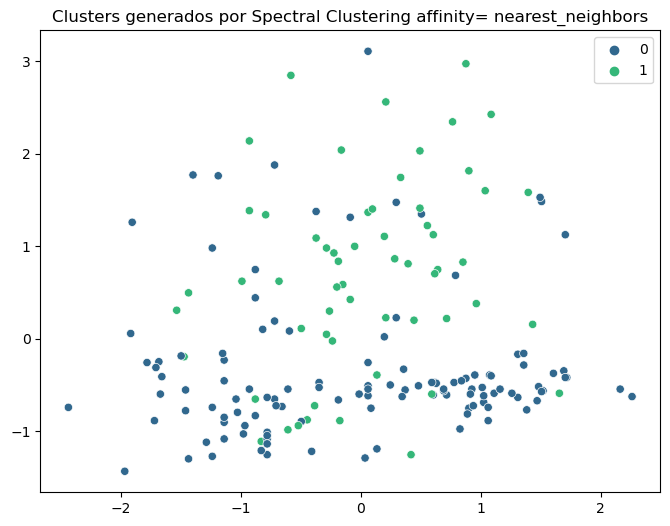

In [186]:
# Inicializar Spectral Clustering
spectral = SpectralClustering(n_clusters=2, random_state=42, affinity='nearest_neighbors')
# Ajustar el modelo
labels_spectral = spectral.fit_predict(wineEscalado)

# Visualización de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wineEscalado[:, 0], y=wineEscalado[:, 1], hue=labels_spectral, palette='viridis')
plt.title('Clusters generados por Spectral Clustering affinity= nearest_neighbors')
plt.show()

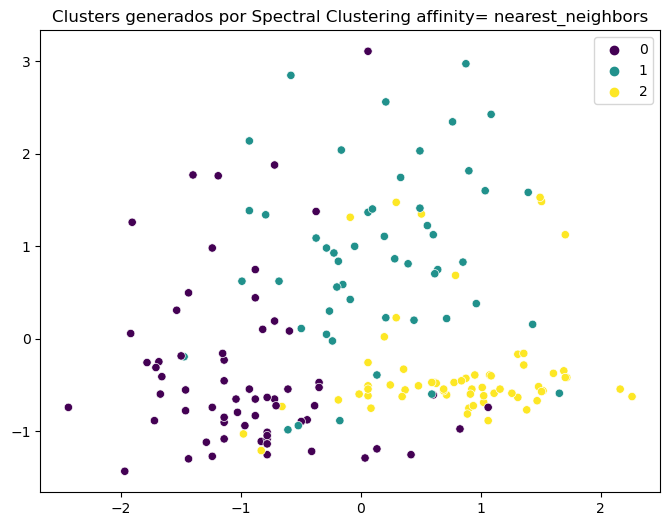

In [187]:
# Inicializar Spectral Clustering
spectral = SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors')

# Ajustar el modelo
labels_spectral = spectral.fit_predict(wineEscalado)

# Visualización de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wineEscalado[:, 0], y=wineEscalado[:, 1], hue=labels_spectral, palette='viridis')
plt.title('Clusters generados por Spectral Clustering affinity= nearest_neighbors')
plt.show()

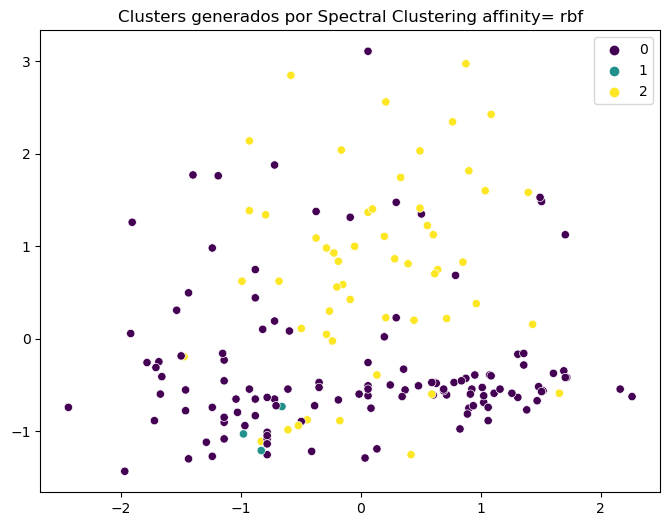

In [188]:
# Inicializar Spectral Clustering
spectral = SpectralClustering(n_clusters=3, random_state=42, affinity='rbf')

# Ajustar el modelo
labels_spectral = spectral.fit_predict(wineEscalado)

# Visualización de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wineEscalado[:, 0], y=wineEscalado[:, 1], hue=labels_spectral, palette='viridis')
plt.title('Clusters generados por Spectral Clustering affinity= rbf')
plt.show()

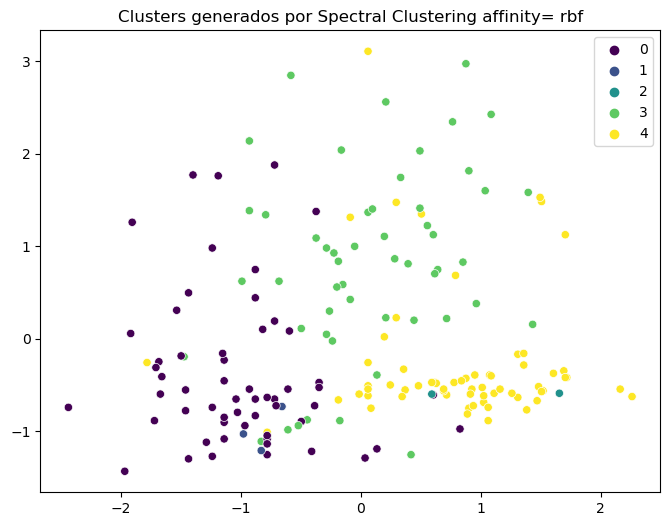

In [189]:
# Inicializar Spectral Clustering
spectral = SpectralClustering(n_clusters=5, random_state=42, affinity='rbf')

# Ajustar el modelo
labels_spectral = spectral.fit_predict(wineEscalado)

# Visualización de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wineEscalado[:, 0], y=wineEscalado[:, 1], hue=labels_spectral, palette='viridis')
plt.title('Clusters generados por Spectral Clustering affinity= rbf')
plt.show()

De las visualizaciones se observa mejor definida aquella con los parámetros: (n_clusters=3, affinity='nearest_neighbors')

### GMM

El uso de Gaussian Mixture Model (GMM) en el conjunto de datos de vinos es debido a su capacidad para modelar distribuciones probabilísticas complejas. Dado que las características de los vinos pueden seguir distribuciones no lineales y contener información oculta en la variabilidad, GMM permite capturar estas estructuras latentes al modelar la distribución de probabilidad conjunta de las variables. Al explorar la complejidad de los vinos, GMM puede identificar patrones subyacentes, tales como la presencia de subgrupos o componentes modales, que podrían no ser capturados eficientemente por métodos más simples. Se aplicará con 3 clusteers ya que ha sido la tendencia hasta ahora

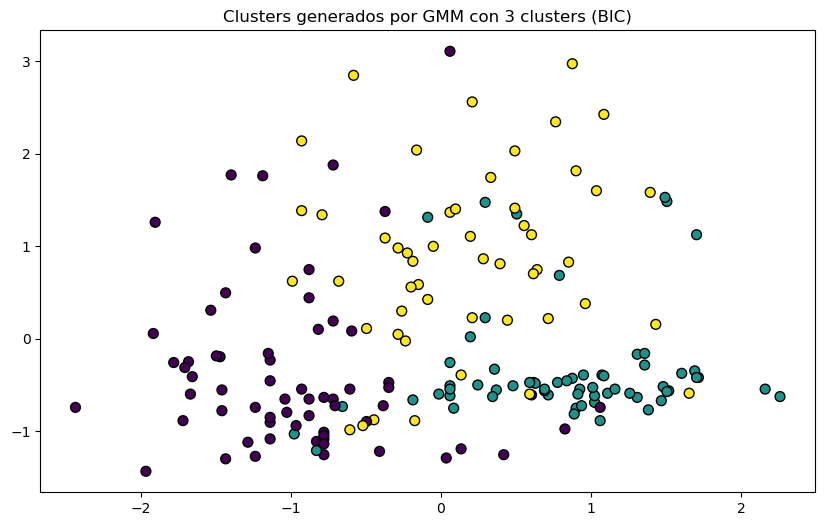

In [190]:
# Inicializar y ajustar el modelo GMM con el número óptimo de clusters según BIC
gmm_optimal = GaussianMixture(n_components=3, random_state=42)
labels_optimal = gmm_optimal.fit_predict(wineEscalado)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(wineEscalado[:, 0], wineEscalado[:, 1], c=labels_optimal, cmap='viridis', s=50, edgecolors='k')
plt.title(f'Clusters generados por GMM con 3 clusters (BIC)')
plt.show()

### Observaciones del proceso de clústering

Después de una exhausiva búsqueda del número adecuado de clusters y realizar el clustering con 3 ptécnicas distintas dentro de las cuáles además se variaban los parámetros, podemos ver con mucha mayor claridad y certeza cuáles son las tendencias presentes en el dataset. Una marcada tendencia a generar **3 grupos** y con una forma muy similar de alojamiento, a como se observa en los espacios de las gráficas hay un cluster abajo a la derecha, otro abajo a la izquiera y uno en el centro, pero también hay detalles mucho más específicos que también representan un patrón, por ejemplo, el **dato localizado hasta la parte superior de la gráfica** aproximadamente a la mitad del eje x, **siempre es clasificado** en el cluster de abajo a la izquierda a pesar de que a primera vista parececiera que debe ser agrupado con el clúster cuyos puntos se encuentran mayormente en la parte superior, por eso y más patrones se seguirá ahondando en esta agrupación, basándonos en el generado por **k means** como representativo de los agrupamientos realizados. 

### Retomando K means

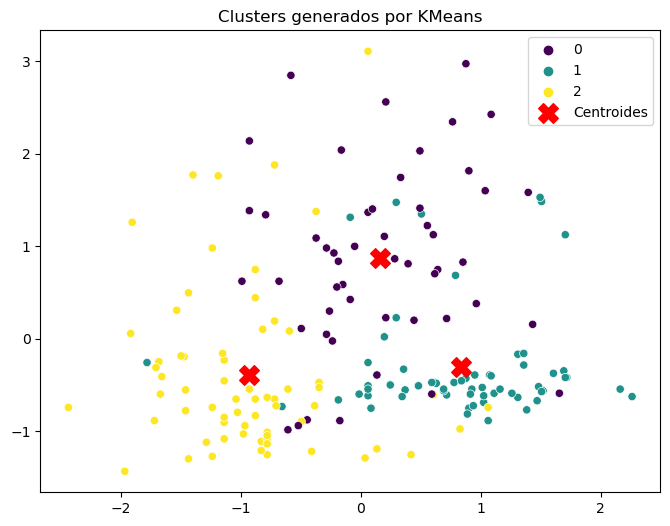

In [191]:
# Inicializar k means
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(wineEscalado)
# Visualización de clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=wineEscalado[:, 0], y=wineEscalado[:, 1], hue=labels, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroides')
plt.title('Clusters generados por KMeans')
plt.legend()
plt.show()

#### Perfil de características

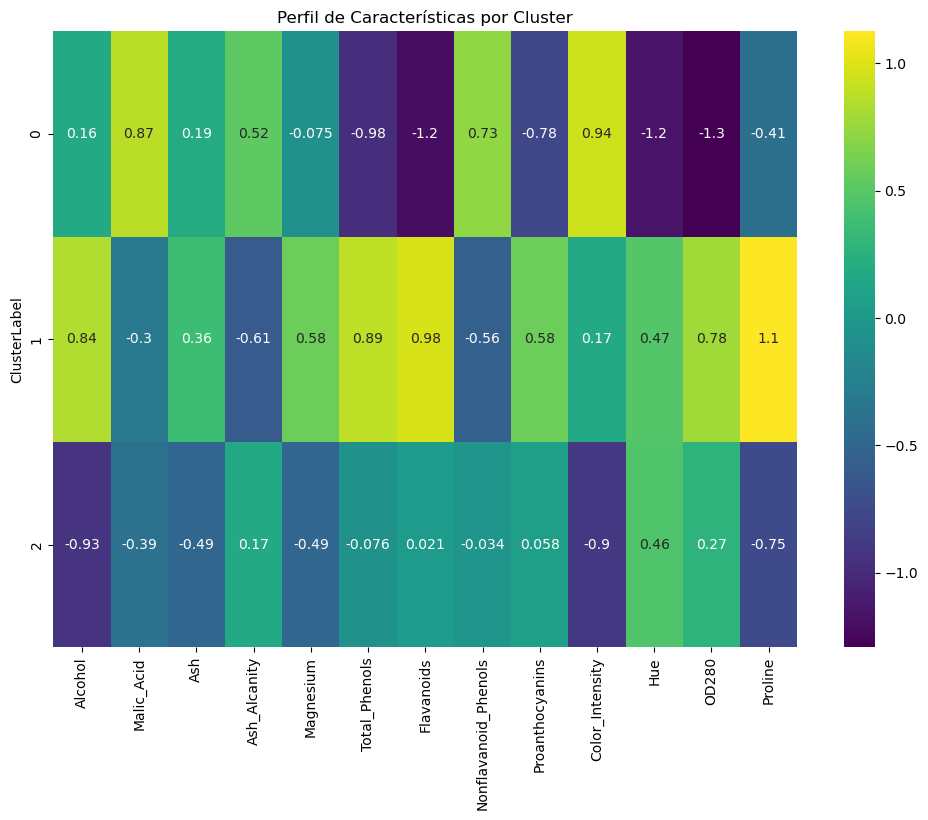

In [192]:
# Convertir el array de Numpy a un DataFrame de Pandas
wine_clustered = pd.DataFrame(data=wineEscalado, columns=['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium', 'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'
])  

# Agregar las etiquetas de los clusters al DataFrame
wine_clustered['ClusterLabel'] = labels

# Calcular la media de cada característica dentro de cada cluster
cluster_means = wine_clustered.groupby('ClusterLabel').mean()

# Visualización
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap='viridis')
plt.title('Perfil de Características por Cluster')
plt.show()


**Interpretación** A este punto ya se han interpretado distintos análisis realizados desde la etapa de exploración hasta la justificación de las decisiones en el clustering, sin embargo, finalmente en el perfil de características se observa cómo el tercer cluster tiene colores significativamente más oscuros en su paleta de colores, esto se traduce a que las medias de los valores para cada característica son mucho menores comparadas con los otros clusters, por ejemplo, el tercer grupo de vino tiene menos cantidad de alcohol, característica que seguro es por lo tanto importante para determinar el grupo al que pertenecerá un vino, así como bajas intensidades en su color, menos ash y menos magnesio. En cambio características como el matiz o hue resulta una característica importante para el primer grupo de vinos, al igual que los Flavanoids y el OD280 ya que destacan por tener medias con valores bajos. El segundo grupo (el de enmedio) resalta por tener medias con valores bastantes altos en Flavonoids y prolina. 

Aterrizando estos hallazgos a un contexto real, aquí están algunas inferencias:

1. **Cluster 1:**
   - **Características Principales:** Destaca por un matiz más intenso, alto contenido de Flavanoids y un OD280 elevado.
   - **Posible Significado:** Este grupo podría representar vinos con perfiles de sabor más intensos y complejos, con colores más pronunciados y propiedades organolépticas distintivas.

2. **Cluster 2:**
   - **Características Principales:** Se distingue por valores notables en Flavanoids y prolina.
   - **Posible Significado:** Este grupo podría representar vinos con un perfil más rico en compuestos aromáticos y con características que sugieren una mayor complejidad sensorial.

3. **Cluster 3:**
   - **Características Principales:** Colores más oscuros, menor contenido de alcohol, baja intensidad de color, menos ash y menos magnesio.
   - **Posible Significado:** Este grupo podría indicar vinos con perfiles más ligeros, menos estructurados y con propiedades más suaves. Podrían ser vinos más livianos y menos concentrados en términos de color y sabor.

Estas interpretaciones pueden proporcionar orientación a enólogos, productores de vino y consumidores sobre qué aspectos químicos y sensoriales pueden esperar de vinos pertenecientes a cada grupo. Además, podrían servir como base para estrategias de comercialización y recomendaciones de maridaje, ya que diferentes grupos pueden apelar a diferentes preferencias de los consumidores.